# **So far**

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random

In [2]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
vocab_size = len(itos)
vocab_size

27

In [5]:
class Linear:
  def __init__(self, fan_in, fan_out, bias = True):
    self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [6]:
class BatchNorm1d:
  def __init__(self, dim, eps = 1e-5, momentum = 0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim = True)
      xvar = x.var(0, keepdim = True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + (self.momentum) * xmean
        self.running_var = (1 - self.momentum) * self.running_var + (self.momentum) * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [7]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

In [8]:
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return []

In [9]:
class Flatten:
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

In [10]:
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [11]:
block_size = 8 # context length: how many characters do we take to predict the next one

def build_dataset(words):
  # build the dataset

  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [12]:
import random
random.shuffle(words)

num1 = len(words) * 0.8
Xtr, Ytr = build_dataset(words[:int(num1)])
Xte, Yte = build_dataset(words[int(num1):])

g = torch.Generator().manual_seed(42)

torch.Size([182583, 8]) torch.Size([182583])
torch.Size([45563, 8]) torch.Size([45563])


In [13]:
n_emb = 10
n_hidden = 100

model = Sequential([
    Embedding(vocab_size, n_emb),
    Flatten(),
    Linear(n_emb * block_size, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
])

with torch.no_grad():
  model.layers[-1].gamma *= 0.1
  for layer in model.layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= (5/3)

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

11081


In [14]:
[model.layers[i].__class__.__name__ for i in range(7)]

['Embedding',
 'Flatten',
 'Linear',
 'BatchNorm1d',
 'Tanh',
 'Linear',
 'BatchNorm1d']

In [15]:
lr = 0.12
epochs = 70000
batch_size = 32
losses = []
ud = []

for epoch in range(epochs + 1):
  if epoch > 50000:
    lr = 0.01

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  for p in parameters:
    p.data += -lr * p.grad

  if epoch % 10000 == 0:
    print(f'{epoch} / {epochs}: {loss.item() : .4f}')
  losses.append(loss.item())

0 / 70000:  3.2996
10000 / 70000:  2.7044
20000 / 70000:  2.4935
30000 / 70000:  2.5750
40000 / 70000:  2.1397
50000 / 70000:  2.3554
60000 / 70000:  1.8683
70000 / 70000:  2.2252


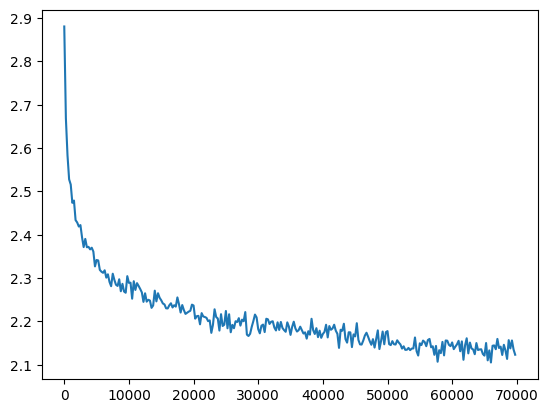

In [16]:
plt.plot([250 * x for x in range(280)],torch.tensor(losses[:-1]).view(-1, 250).mean(1))

In [17]:
for layer in model.layers:
  layer.training = False

In [18]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
      'train' : (Xtr, Ytr),
      'test' : (Xte, Yte)
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(f'Model loss : {loss.item() : .4f}')

# put layers into eval mode
for layer in model.layers:
  layer.training = False

split_loss("train")
split_loss("test")

Model loss :  2.0836
Model loss :  2.1238


In [19]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mriani.
yazziee.
medhayah.
rethrs.
ejdrlen.
adelynne.
illemi.
jenreden.
vangean.
kayzion.
kalin.
shubergahi.
jestin.
jowelle.
jettrif.
ubren.
dariyah.
fmehs.
kayshawn.
yamihan.


## **RESULT**

```
BATCH SIZE  |  PERFORMANCE
--------------------------------
    3       |  train = 2.1227
            |   test = 2.1605
--------------------------------
    8       |  train = 2.0836
            |   test = 2.1238
--------------------------------
```

# **Wavenet**

![Wavenet](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-24_at_12.11.35_AM_uO4kv1I.png)

It only involves the last layer alone in matrix multiplication

(1 2) (3 4) (5 6) (7 8) => needs to create batches and process in parallel

In [20]:
(torch.randn(4,5,6,80) @ torch.randn(80, 10)).shape

torch.Size([4, 5, 6, 10])

In [21]:
e = torch.randn(4,8,10) # goal : want this to be (4 * 4 * 20) where consecutive 10-d vectors gets concatenated
exp1 = e.view(e.shape[0], -1 , e.shape[2]*2) # big brain!! :)
exp2 = torch.cat([e[: , ::2, : ], e[:, 1::2, :]], dim = 2)
print(torch.all(exp1 == exp2))

tensor(True)


In [22]:
# ------------------------------------------------------------------------------

class Linear:
  def __init__(self, fan_in, fan_out, bias = True):
    self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# ------------------------------------------------------------------------------\

class BatchNorm1d:
  def __init__(self, dim, eps = 1e-5, momentum = 0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      if x.ndim == 2:
        dim = 0
      if x.ndim == 3:
        dim = (0, 1)           # we need it (1, 1, n)

      xmean = x.mean(0, keepdim = True)
      xvar = x.var(0, keepdim = True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + (self.momentum) * xmean
        self.running_var = (1 - self.momentum) * self.running_var + (self.momentum) * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# ------------------------------------------------------------------------------

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

# ------------------------------------------------------------------------------

class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return []

# ------------------------------------------------------------------------------

class FlattenWNT:
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    assert T % self.n == 0, f"Dimension mismatch: {T} cannot be divided by {self.n}"
    x = x.view(B, T // self.n, C * self.n)

    if x.shape[1] == 1:
      x = x.squeeze(1)

    self.out = x
    return self.out

  def parameters(self):
    return []

# ------------------------------------------------------------------------------

class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

# ------------------------------------------------------------------------------


In [23]:
block_size = 8 # context length: how many characters do we take to predict the next one

def build_dataset(words):
  # build the dataset

  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [24]:
import random
random.shuffle(words)

num1 = len(words) * 0.8
Xtr, Ytr = build_dataset(words[:int(num1)])
Xte, Yte = build_dataset(words[int(num1):])

g = torch.Generator().manual_seed(42)

torch.Size([182536, 8]) torch.Size([182536])
torch.Size([45610, 8]) torch.Size([45610])


In [25]:
n_emb = 10
n_hidden = 68 # for getting identical number of parameters

model = Sequential([
    Embedding(vocab_size, n_emb),
    FlattenWNT(2), Linear(n_emb * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenWNT(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenWNT(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1
  for layer in model.layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= (5/3)

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

22127


In [26]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pass
logits = model(Xb)
Xb.shape

torch.Size([4, 8])

In [27]:
stat = [[layer.__class__.__name__, tuple(layer.out.shape)] for layer in model.layers]
for layer, shape in stat:
  print(f'{layer} : {shape}')

Embedding : (4, 8, 10)
FlattenWNT : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenWNT : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenWNT : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [28]:
lr = 0.12
epochs = 70000
batch_size = 32
losses = []
ud = []

for epoch in range(epochs + 1):
  if epoch > 50000:
    lr = 0.01

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  for p in parameters:
    p.data += -lr * p.grad

  if epoch % 10000 == 0:
    print(f'{epoch} / {epochs}: {loss.item() : .4f}')
  losses.append(loss.item())

0 / 70000:  3.2775
10000 / 70000:  2.0665
20000 / 70000:  2.1711
30000 / 70000:  2.3255
40000 / 70000:  2.2173
50000 / 70000:  2.2575
60000 / 70000:  2.0472
70000 / 70000:  2.0994


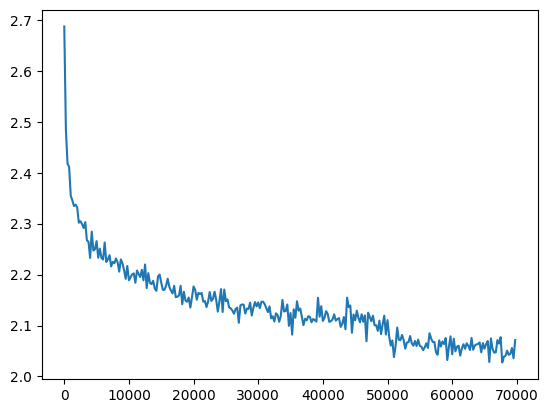

In [29]:
plt.plot([250 * x for x in range(280)],torch.tensor(losses[:-1]).view(-1, 250).mean(1))

In [30]:
for layer in model.layers:
  layer.training = False

In [31]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
      'train' : (Xtr, Ytr),
      'test' : (Xte, Yte)
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(f'Model loss : {loss.item() : .4f}')

# put layers into eval mode
for layer in model.layers:
  layer.training = False

split_loss("train")
split_loss("test")

Model loss :  2.0183
Model loss :  2.0691


In [32]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

morabimyah.
seelen.
hayla.
rethan.
ejdrlee.
adered.
elilee.
parelle.
elissope.
raylynn.
honel.
nyshub.
roshirie.
trinton.
kyrin.
teron.
ubekted.
ryyah.
faela.
kaysh.


**WAVENET RESULTS**

 ```
 BATCH SIZE  |  PERFORMANCE
--------------------------------
 Wavenet(8)  |  train = 2.0183
             |   test = 2.0691
--------------------------------
```

# **EXPERIMENTATION**

In [33]:
def build_dataset(words, block_size):
  # build the dataset

  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y


In [34]:
def train_model(Xtr, Ytr, N, n_emb, n_hidden,batch_size):
  lr = 0.12
  epochs = 70000
  losses = []
  params = []

  model = Sequential([
    Embedding(vocab_size, n_emb),
    FlattenWNT(N), Linear(n_emb * N, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenWNT(N), Linear(n_hidden * N, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenWNT(N), Linear(n_hidden * N, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
  ])


  with torch.no_grad():
    model.layers[-1].weight *= 0.1
    for layer in model.layers[:-1]:
      if isinstance(layer, Linear):
        layer.weight *= (5/3)
  parameters = model.parameters()
  params.append(sum(p.nelement() for p in parameters))

  for p in parameters:
    p.requires_grad = True

  for epoch in range(1, epochs + 2):
    if epoch > 50000:
      lr = 0.01

    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]


    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
      p.data += -lr * p.grad

    if epoch % 7000 == 0:
      print(f"{'# ' * (epoch // 7000) + '  ' * (10 - (epoch // 7000)) } : {(epoch // 700):<3} % | Loss : {loss : .4f}")
    losses.append(loss.item())

  return losses, params, model

In [35]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(x, y ,text, model):
  for layer in model.layers:
    layer.training = False

  logits = model(x)
  loss = F.cross_entropy(logits, y)
  loss = f'{loss : .4f}'

  return loss

In [36]:
num1 = len(words) * 0.8

def validate(size, N, n_emb, n_hidden, batch_size, block_size):
  params = []
  model_name = []
  tr_l =[]
  te_l =[]

  print('Training started!')

  plt.figure(figsize = (10, 5))
  for k in range(size):
    mod_name = f'Wavenet_mod - {k+1}'
    print(mod_name)
    random.shuffle(words)
    Xtr, Ytr = build_dataset(words[:int(num1)], block_size[k])
    Xte, Yte = build_dataset(words[int(num1):], block_size[k])


    model_name.append(mod_name)
    losses, params_count, model = train_model(Xtr, Ytr, N[k],n_emb[k], n_hidden[k],batch_size[k])
    params.append(params_count)

    plt.plot([250 * x for x in range(280)],torch.tensor(losses[:-1]).view(-1, 250).mean(1), label = mod_name)

    train_loss = split_loss(Xtr, Ytr, 'train', model)
    test_loss = split_loss(Xte, Yte, 'test', model)

    tr_l.append(train_loss)
    te_l.append(test_loss)

    print()

  plt.legend()

  return params, model_name, tr_l, te_l

In [37]:
def printResult(N, n_emb,n_hidden,batch_size, block_size, params_count, model_name, train_loss, test_loss):
  strn = '|   model_name   |   N   |  n_emb | n_hidden | batch_size | block_size | params_count | train_loss | test_loss |'

  print(f'Model Evaluations')
  print('-' * len(strn))
  print(strn)
  print('-' * len(strn))

  for k in range(len(N)):
    model_strn = f'|{model_name[k]:^12}|{N[k]:^7}|{n_emb[k]:^8}|{n_hidden[k]:^10}|{batch_size[k]:^12}|{block_size[k]:^12}|{params_count[k][0]:^14}|{train_loss[k]:^12}|{test_loss[k]:^11}|'

    print(model_strn)


Training started!
Wavenet_mod - 1
#                    : 10  % | Loss :  2.2470
# #                  : 20  % | Loss :  2.1113
# # #                : 30  % | Loss :  1.9036
# # # #              : 40  % | Loss :  2.0780
# # # # #            : 50  % | Loss :  2.1322
# # # # # #          : 60  % | Loss :  2.0831
# # # # # # #        : 70  % | Loss :  1.8290
# # # # # # # #      : 80  % | Loss :  1.5803
# # # # # # # # #    : 90  % | Loss :  2.3329
# # # # # # # # # #  : 100 % | Loss :  2.3267

Wavenet_mod - 2
#                    : 10  % | Loss :  2.2441
# #                  : 20  % | Loss :  2.0627
# # #                : 30  % | Loss :  2.0528
# # # #              : 40  % | Loss :  1.7797
# # # # #            : 50  % | Loss :  2.1155
# # # # # #          : 60  % | Loss :  1.7937
# # # # # # #        : 70  % | Loss :  2.2004
# # # # # # # #      : 80  % | Loss :  1.7017
# # # # # # # # #    : 90  % | Loss :  2.1851
# # # # # # # # # #  : 100 % | Loss :  2.3261

Wavenet_mod - 3
#           

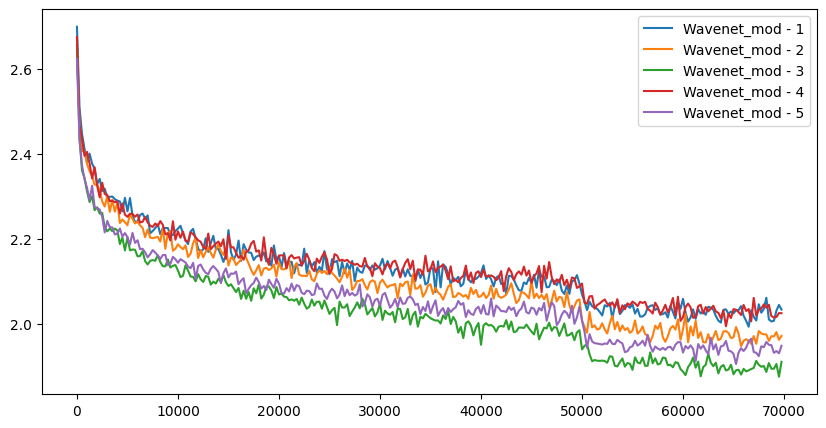

In [39]:
N  = [2, 2, 2, 3, 3]
n_emb = [8, 10, 12, 10, 12]
n_hidden = [100, 150, 150, 100, 150]
batch_size = [32, 32, 48, 32, 48]
block_size = [8, 8, 8, 27, 27]

params, mod_name, tr_l, te_l = validate(len(N), N, n_emb, n_hidden, batch_size, block_size)

printResult(N, n_emb, n_hidden, batch_size, block_size, params, mod_name, tr_l, te_l)

**Hence the model with N = 2, n_emb = 12, batch_size = 48 and block_size = 8, performs well**

Final evaluations

```
----------------------------------------------------------------------------------------------------------------
|   model_name  |   N   |  n_emb | n_hidden | batch_size | block_size | params_count | train_loss | test_loss |
----------------------------------------------------------------------------------------------------------------
|Wavenet_mod - 1|   2   |   8    |   100    |     32     |     8      |    44927     |   1.9867   |   2.0498  |
|Wavenet_mod - 2|   2   |   10   |   150    |     32     |     8      |    97977     |   1.9359   |   2.0204  |
|Wavenet_mod - 3|   2   |   12   |   150    |     48     |     8      |    98577     |   1.8670   |   2.0042  |
|Wavenet_mod - 4|   3   |   10   |   100    |     32     |     27     |    66327     |   2.2490   |   2.3064  |
|Wavenet_mod - 5|   3   |   12   |   150    |     48     |     27     |    145377    |   2.1636   |   2.2360  |
----------------------------------------------------------------------------------------------------------------
```